<h1 style="text-decoration :underline;color:red">Prédiction du vainqueur :</h1>

<p style="color:blue">Le but de ce notebook est de déterminer le vainqueur entre le favori et le challenger ainsi que la probabilité de victoire de chacun des joueurs. Ensuite on cherchera à déterminer l'écart significatif entre nos probabilités de victoires et celles des bookmakers pour parier sur les bons matchs afin d'obtenir le meilleur gain, ROI.</p>

<h2 style="text-decoration :underline;color:green">Module utilisé lors de ce notebook :</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score,balanced_accuracy_score,make_scorer
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,classification_report

pd.set_option('max_columns', 40)

<h2 style="text-decoration :underline;color:green">lecture du fichier:</h2>

In [2]:

df = pd.read_csv("data_clean_all.csv",index_col=0)

<h2 style="text-decoration :underline;color:green">nettoyage des features + proba_elo_F et C:</h2>

In [3]:
#on enlève les variables non pertinentes pour l'algo

df= df.drop(["Favori","Challenger","Comment","Tournament","Round","Location","Date","Series","ATP","Winner","Wsets","Lsets","B365_F","B365_C","proba_elo_F","proba_elo_C"],axis=1)
df = df.reset_index().drop("index",axis=1)

In [4]:
df

,Rank_F,PS_F,elo_F,TV_F,TV_surf_F,sets_F,Rank_C,PS_C,elo_C,TV_C,TV_surf_C,sets_C,Court,Surface,Best of,Vainqueur,moy_elo_F,moy_elo_C
0,58,1.719,1618.182210,0.500000,0.500000,0.0,246,2.21,1486.195239,0.428571,0.500000,0.0,Outdoor,Hard,3,challenger,-36.522332,-20.871951
1,6,1.385,1820.759485,0.763158,0.720000,0.0,43,3.25,1615.057648,0.461538,0.428571,0.0,Outdoor,Hard,3,challenger,19.791315,41.588209
2,39,1.746,1654.468551,0.666667,0.600000,0.0,67,2.18,1588.330984,0.571429,0.555556,0.0,Outdoor,Hard,3,favori,15.865896,40.962208
3,52,2.060,1584.479208,0.571429,0.500000,0.0,96,1.82,1569.027967,0.461538,0.454545,0.0,Outdoor,Hard,3,favori,-4.357656,34.077361
4,92,1.455,1452.260713,0.444444,0.333333,0.0,99,2.90,1493.478855,0.666667,0.000000,0.0,Outdoor,Hard,3,favori,-61.224824,-10.241221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28985,15,2.430,1842.459807,0.772727,0.772727,11.0,23,1.65,1835.901543,0.631579,0.631579,9.0,Outdoor,Hard,3,challenger,48.408738,165.883261
28986,8,1.340,1843.576914,0.611111,0.611111,6.0,59,3.63,1647.967561,0.428571,0.428571,4.0,Outdoor,Hard,3,favori,29.784931,46.204092
28987,69,2.090,1619.758421,0.500000,0.571429,9.0,73,1.85,1588.293069,0.692308,0.800000,9.0,Indoor,Clay,3,challenger,-61.940388,79.942472
28988,8,2.750,1851.413609,0.666667,0.666667,9.0,9,1.52,1966.532849,0.800000,0.800000,9.0,Outdoor,Hard,3,challenger,39.699484,220.827893


<hr>
<h2 style="text-decoration :underline;color:green">Séparation feature et target</h2>

In [5]:
target = df.Vainqueur

In [6]:
#on enlève les cotes des bookmaker pour ne pas être biaisé par leur valeur.
data =  df.drop(["Vainqueur","PS_C","PS_F"],axis=1)


<hr>
<h2 style="text-decoration :underline;color:green">Normalisation des données </h2>

<h3 style="text-decoration :underline;color:blue">Variables catégorielles </h3>

In [7]:
#transformation en variables indicatrices
cat = data.loc[:,data.dtypes==np.object]
cat = pd.get_dummies(cat,drop_first=True)


In [8]:
bestof = pd.get_dummies(df['Best of'],prefix='Best_of',drop_first=True)


In [9]:
categorical = cat.join(bestof)


In [10]:
categorical

,Court_Outdoor,Surface_Clay,Surface_Grass,Surface_Hard,Best_of_5
0,1,0,0,1,0
1,1,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,0,0,1,0
...,...,...,...,...,...
28985,1,0,0,1,0
28986,1,0,0,1,0
28987,0,1,0,0,0
28988,1,0,0,1,0


<h3 style="text-decoration :underline;color:blue">Variables numériques </h3>

In [11]:
#normalisation
num= data.select_dtypes(include='number')
num = num.drop("Best of", axis=1)
scaler = MinMaxScaler()
num_scaled = pd.DataFrame(scaler.fit_transform(num), columns = num.columns)
num_scaled.shape

(28990, 12)

<h3 style="text-decoration :underline;color:blue">Features finales </h3>

In [12]:
#jonction des variables numériques et  catégorielles
data = num_scaled.join(categorical)

data

,Rank_F,elo_F,TV_F,TV_surf_F,sets_F,Rank_C,elo_C,TV_C,TV_surf_C,sets_C,moy_elo_F,moy_elo_C,Court_Outdoor,Surface_Clay,Surface_Grass,Surface_Hard,Best_of_5
0,0.059548,0.271326,0.500000,0.500000,0.000000,0.129237,0.163230,0.428571,0.500000,0.000000,0.729413,0.295515,1,0,0,1,0
1,0.006160,0.461984,0.763158,0.720000,0.000000,0.021716,0.292835,0.461538,0.428571,0.000000,0.779021,0.376405,1,0,0,1,0
2,0.040041,0.305477,0.666667,0.600000,0.000000,0.034428,0.265955,0.571429,0.555556,0.000000,0.775563,0.375594,1,0,0,1,0
3,0.053388,0.239606,0.571429,0.500000,0.000000,0.049788,0.246540,0.461538,0.454545,0.000000,0.757747,0.366678,1,0,0,1,0
4,0.094456,0.115166,0.444444,0.333333,0.000000,0.051377,0.170555,0.666667,0.000000,0.000000,0.707651,0.309282,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28985,0.015400,0.482408,0.772727,0.772727,0.500000,0.011123,0.514953,0.631579,0.631579,0.333333,0.804231,0.537375,1,0,0,1,0
28986,0.008214,0.483459,0.611111,0.611111,0.272727,0.030191,0.325935,0.428571,0.428571,0.148148,0.787825,0.382382,1,0,0,1,0
28987,0.070842,0.272809,0.500000,0.571429,0.409091,0.037606,0.265916,0.692308,0.800000,0.333333,0.707021,0.426076,0,1,0,0,0
28988,0.008214,0.490835,0.666667,0.666667,0.409091,0.003708,0.646338,0.800000,0.800000,0.333333,0.796559,0.608532,1,0,0,1,0


<hr>
<h2 style="text-decoration :underline;color:green">Séparation set entrainement et set test </h2>

In [13]:
X_train,X_test,y_train,y_test = train_test_split(data,target,shuffle=False,test_size=0.2,random_state=1000)

<hr>
<h2 style="text-decoration :underline;color:green">Amélioration des résultats XGBoost avec la validation croisée </h2>

In [14]:
# parametre pour XGBoost
params = {
        'min_child_weight': list(np.arange(1,10,1)),
        'gamma': list(np.arange(0.5,5,0.5)),
        'subsample': list(np.arange(0.5,1,0.1)),
        'colsample_bytree': list(np.arange(0.5,1,0.1)),
        'max_depth': list(np.arange(3,5,1))
        }

In [15]:
#création du classifieur
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [16]:
#validation croisée + recherche des meilleurs hyperparametres avec randomized
folds = 30
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

Fitting 30 folds for each of 5 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.0min finished
C:\Users\Anthony\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:13:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000016F1A0FAC80>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.02,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, mis...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7,
                    

In [17]:
random_search.score(X_test,y_test)

0.6734185746701331

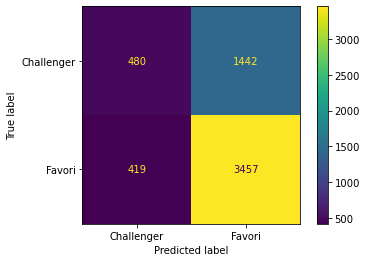

In [18]:
plot_confusion_matrix(random_search,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Challenger","Favori"])

In [19]:
#récupération des probabilités de victoires
y_pr = random_search.predict(data)
predict =  pd.DataFrame(y_pr,index=data.index ,columns=["Prediction"])
y_pred = random_search.predict_proba(data)
proba = pd.DataFrame(y_pred,index=data.index ,columns=["Proba_Challenger","Proba_Favori"])

<AxesSubplot:>

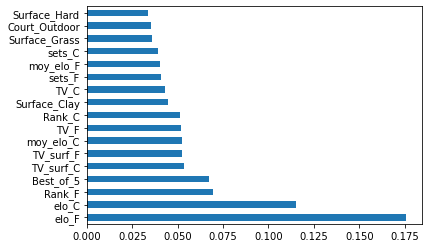

In [20]:
feat= pd.Series(random_search.best_estimator_.feature_importances_,index=X_train.columns)
feat.nlargest(20).plot(kind='barh')

In [21]:
predictions=random_search.predict(X_test)

In [22]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

  challenger       0.53      0.25      0.34      1922
      favori       0.71      0.89      0.79      3876

    accuracy                           0.68      5798
   macro avg       0.62      0.57      0.56      5798
weighted avg       0.65      0.68      0.64      5798



<h3 style="text-decoration :underline;color:blue">Sauvegarde du dataframe pari  </h3>

In [23]:
#création du dataframe pari
pari = df[["PS_C","PS_F","Vainqueur"]]

#ajout de la prédiction
pari = pari.join(predict)

#ajout des proba de prediction
pari = pari.join(proba)

#export du fichier pari pour éviter de relancer l'algo xgboost (qui est long) à chaque fois
pari.to_csv("pariXGBoostBetter.csv")

<hr>
<h2 style="text-decoration :underline;color:green">Création d'un dataframe pari pour étudier les écarts entre les probabilités algo et bookmaker </h2>

<p style="color:blue">D'après notre étude préliminiaire du dataset, nous avons remarqué que le bookmaker Pinnacle est beaucoup plus généreux que Bet365 avec un ROI de -2% pour Pinnacle contre -6.5% pour Bet365. On prendra uniquement les cotes de Pinnacle pour la suite de notre étude.</p>

<h2> Choix de l'algo pour le ROI </h2>

In [24]:
#lecture du fichier pari
pari = pd.read_csv("pariXGBoostBetter.csv",index_col=0)

In [25]:
#ajout de l'indice de confiance sur la cote
pari["proba_PS_Challenger"]=1/pari.PS_C
pari["proba_PS_Favori"]=1/pari.PS_F

pari["gain_theoriq_F"] = pari.Proba_Favori*pari.PS_F
pari["gain_theoriq_C"] =  pari.Proba_Challenger*pari.PS_C

pari["gain_confiance"]="wait"

for i in range(len(pari)):
    if pari["Prediction"][i]== "favori":
        pari["gain_confiance"][i]= pari["gain_theoriq_F"][i]
    else:
        pari["gain_confiance"][i]= pari["gain_theoriq_C"][i]

<ipython-input-25-06badfe1e5cb>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["gain_confiance"][i]= pari["gain_theoriq_F"][i]
<ipython-input-25-06badfe1e5cb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["gain_confiance"][i]= pari["gain_theoriq_C"][i]


In [26]:
#détermination de victoire du pari
pari["pari gagné"]=2
for i in range(len(pari)):
    if pari.Vainqueur[i] == pari.Prediction[i]:
        pari["pari gagné"][i]=1
    else:
        pari["pari gagné"][i]=0

#choix de la cote en fonction de la prediction
pari["cote"]=1.1
for i in range(len(pari)): 
    if pari.Prediction[i]=="favori":
        pari.cote[i] = pari.PS_F[i]
    else:
        pari.cote[i] = pari.PS_C[i]

#rangement en fonction de l'indice de confiance        
pari.sort_values(by = 'gain_confiance', ascending = False, inplace = True)

<ipython-input-26-f8aa0124b89c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["pari gagné"][i]=0
<ipython-input-26-f8aa0124b89c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari["pari gagné"][i]=1
<ipython-input-26-f8aa0124b89c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pari.cote[i] = pari.PS_F[i]
<ipython-input-26-f8aa0124b89c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

<hr>
<h2 style="text-decoration :underline;color:green">Calcul du gain et du ROI en fonction du nombre de match </h2>

In [27]:
#création d'un dataframe test pour pouvoir tester plusieurs parametres essentiellement les cotes ici par exemple
test = pari
#test= test[test.Prediction == test.choix]
#on les range par indice décroissant
test.sort_values(by = 'gain_confiance', ascending = False, inplace = True)

test = test.reset_index().drop("index",axis=1)

In [28]:
test.to_csv("test.csv")

In [29]:
test.head(50)

,PS_C,PS_F,Vainqueur,Prediction,Proba_Challenger,Proba_Favori,proba_PS_Challenger,proba_PS_Favori,gain_theoriq_F,gain_theoriq_C,gain_confiance,pari gagné,cote
0,1.090,9.550,challenger,favori,0.426066,0.573934,0.917431,0.104712,5.481072,0.464412,5.48107,0,9.55
1,8.080,1.120,favori,challenger,0.561018,0.438983,0.123762,0.892857,0.491660,4.533021,4.53302,0,8.08
2,1.232,4.910,challenger,favori,0.127049,0.872951,0.811688,0.203666,4.286188,0.156525,4.28619,0,4.91
3,1.126,8.150,challenger,favori,0.494486,0.505514,0.888099,0.122699,4.119941,0.556791,4.11994,0,8.15
4,1.232,4.910,challenger,favori,0.164656,0.835344,0.811688,0.203666,4.101538,0.202856,4.10154,0,4.91
5,1.167,6.400,favori,favori,0.427987,0.572013,0.856898,0.156250,3.660882,0.499461,3.66088,1,6.40
6,1.150,6.160,challenger,favori,0.419201,0.580799,0.869565,0.162338,3.577721,0.482081,3.57772,0,6.16
7,1.160,6.700,challenger,favori,0.466916,0.533084,0.862069,0.149254,3.571661,0.541623,3.57166,0,6.70
8,1.171,6.350,challenger,favori,0.437601,0.562399,0.853971,0.157480,3.571231,0.512431,3.57123,0,6.35
9,1.162,6.590,challenger,favori,0.466482,0.533518,0.860585,0.151745,3.515883,0.542052,3.51588,0,6.59


In [30]:
#fonction calculant le gain pour n match pariés
def gain(n):
    gain = 0.1
    argent = 0.1
    gain_roi = []
    mise_totale = 0
    for i in range(n):
        mise = 1
        if test["pari gagné"][i] == 1:
                argent += mise * test.loc[i,"cote"] -1
        else:
                argent -= mise
    #print(f"pour {n} matchs, vous avez gagné {round(argent,2)} et le rendement est de {ROI}% ")
    return argent

#fonction calculant le ROI pour n match (c'est la meme fonction qu'au dessus mais je n'arrive pas à récupérer séparemment les valeurs du tuple ensuite)
def Rent(n):
    gain = 0.1
    argent = 0.1
    gain_roi = []
    mise_totale = 0
    for i in range(n):
        mise = 1
        if test["pari gagné"][i] == 1:
                gain += mise * test["cote"][i]
                argent += mise * test.loc[i,"cote"] -1
        else:
                argent -= mise
                gain += 0
        mise_totale += mise
    ROI = (gain -  n)/ n + 1 
    #print(f"pour {n} matchs, vous avez gagné {round(argent,2)} et le rendement est de {ROI}% ")
    return ROI

In [31]:
#création d'une liste de  gain en fonction du nombre de match parié
nombre_de_paris = np.linspace(1,len(test),50,dtype=int)
gain_pari = []
ROI=[]
for i in nombre_de_paris:
    gain_pari.append(gain(i))
    ROI.append(Rent(i))    

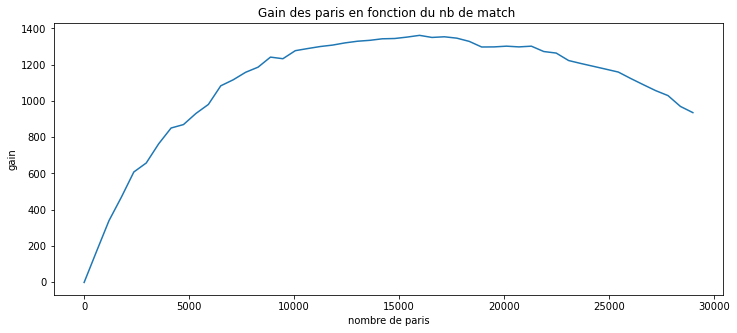

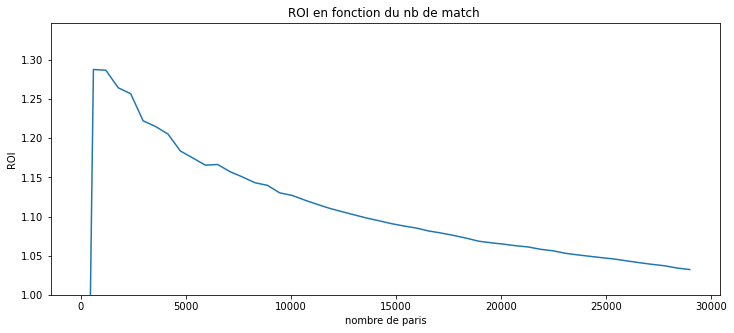

In [32]:
#affichage des gains en fonction du nombre de match pariés
plt.figure(figsize=(12,5))
plt.plot(nombre_de_paris, gain_pari)
plt.xlabel('nombre de paris')
plt.ylabel('gain');
plt.title(f"Gain des paris en fonction du nb de match ")
plt.show()

#affichage des gains en fonction du nombre de match pariés
plt.figure(figsize=(12,5))
plt.plot(nombre_de_paris, ROI)
plt.xlabel('nombre de paris')
plt.ylabel('ROI');
plt.title(f"ROI en fonction du nb de match ")
plt.ylim(1)
plt.show()
